## Seminario de Ciencias de la Computación A: Neuronas y redes neuronales: modelos y aplicaciones a la ciencia de datos
--- 

Notebook for model hiperparameter tunning using `GridSearchCV` and `KerasRegressor`.

### Developed by:
- Brito Juárez Britny
- Medel Piña Alberto Natanael
- Medina Ruiz Arturo Itzcóatl
- Ramírez Plascencia Tania

In [2]:
# Scikitlearn asking for a specific version of numpy
!pip install "numpy>=1.16.5,<1.23.0"
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 11.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.1 which is incompatible.
chex 0.1.84 requires numpy>=1.24.1, but you have numpy 1.22.4 which is incompatible.
inequality 1.0.1 requires numpy>=1.23, but you have numpy 1.22.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.6.0 requires sh

In [ ]:
!lscpu | grep -vE "Vulnerability"

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as plt
import tensorflow.keras as keras

In [4]:
# Cration of time windows
def time_window(series, step_length, target_column):
  # X for attributes Y for target
  X_series = X_test = []
  Y_series = Y_test = []
  last = len(series) - sequence_length - 1
  for i in range(last):
    X_series.append(series[i : i + sequence_length])
    Y_series.append(series[i + sequence_length, target_column])

  X_series = np.array(X_series)
  Y_series = np.array(Y_series)
  X_series = np.delete(X_series, target_column, 2) # Drop target from training
  return X_series, Y_series

In [5]:
#train set generated with data() function. See 
train = pd.read_feather('/kaggle/input/clean02/training_30m_100p_gap.feather')
train = train[['Close_Norm', 'High_Norm', 'Low_Norm', 'Gap',
               'Close_Rate', 'Volume_Log', 'Volume_Qty']]
sequence_length = 30
train_vals = train.values

X_train, Y_train = time_window(train_vals, sequence_length, 0)
print(X_train.shape , Y_train.shape)

(80529, 30, 6) (80529,)


In [6]:
#train set generado por la función data()
validation = pd.read_feather('/kaggle/input/clean02/validation_30m_100p_gap.feather')
validation = validation[['Close_Norm', 'High_Norm', 'Low_Norm', 'Gap',
                         'Close_Rate', 'Volume_Log', 'Volume_Qty']]

validation_vals = validation.values
X_val, Y_val = time_window(validation_vals, sequence_length, 0)
X_val.shape, Y_val.shape

((20108, 30, 6), (20108,))

## Optimización de hiperparámetros

In [7]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import pickle

# Network Weight Initialization

In [12]:
# Function to create a model for KerasRegressor
def create_model_weight(init_mode):
    # Model structure
    model = keras.Sequential()
    model.add(keras.layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=init_mode))
    model.add(keras.layers.Dense(1))
    # Model compilation
    model.compile(optimizer='adam', loss=keras.losses.Huber(), metrics=['mae'])
    return model


In [ ]:
# Create a model with wrapper for sckitlearn
model = KerasRegressor(model=create_model_weight, epochs=100, batch_size=10, verbose=0)
# Grid search parameters: normal, glorot_uniform, orthoonal
init_mode = ['normal', 'glorot_uniform', 'orthogonal']
param_grid = dict(model__init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_val, Y_val)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
with open('weights_init.pickle', 'wb') as target:
    pickle.dump(grid_result, target, protocol=pickle.HIGHEST_PROTOCOL)

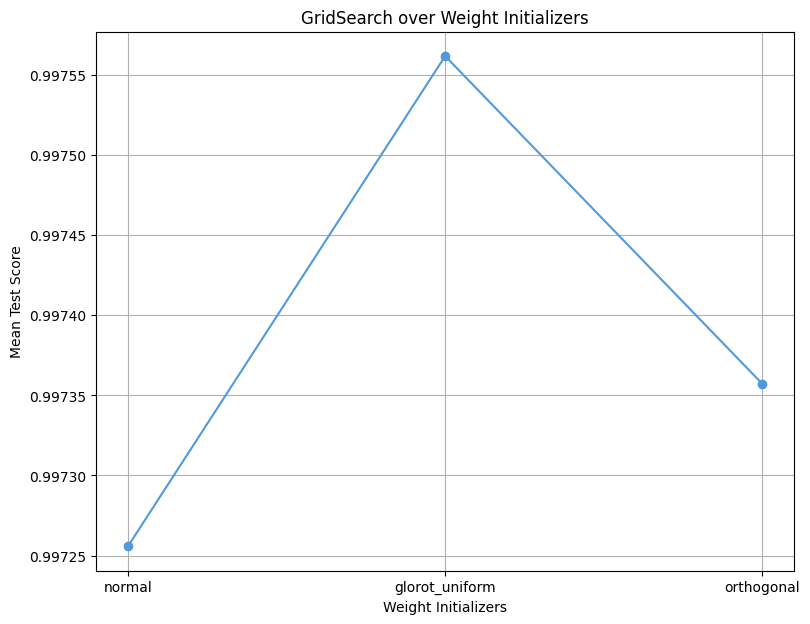

In [13]:
# Don't foret to run the 'create_model_weight()' cell
with open('weights_init.pickle', 'rb') as weight_results:
    load = pickle.load(weight_results)
w_result = load.cv_results_['param_model__init_mode']
w_means = load.cv_results_['mean_test_score']
plt.pyplot.figure(figsize=(9,7))
plt.pyplot.plot(w_result, w_means, marker='o', linestyle='-', color='#5199dd')
plt.pyplot.xlabel('Weight Initializers')
plt.pyplot.ylabel('Mean Test Score')
plt.pyplot.title('GridSearch over Weight Initializers')
plt.pyplot.grid(True)
plt.pyplot.savefig('GridSearchCV_weights_saved')
plt.pyplot.show()

# Number of Neurons in the Hidden Layer

In [14]:
# Function to create a model for KerasRegressor tunning number
# of neurons
def create_model_neurons(neurons):
    # Model structure
    model = keras.Sequential()
    model.add(keras.layers.LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dense(1))
    # Model compilation
    model.compile(optimizer='adam', loss=keras.losses.Huber(), metrics=['mae'])
    return model


In [ ]:
# Create a model with wrapper for sckitlearn
model = KerasRegressor(model=create_model_neurons, epochs=100, batch_size=10, verbose=0)
# Grid search parameters: 10, 15, 25, 50
neurons = [10, 15, 25, 50]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_val, Y_val)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
with open('num_neurons.pickle', 'wb') as target:
    pickle.dump(grid_result, target, protocol=pickle.HIGHEST_PROTOCOL)

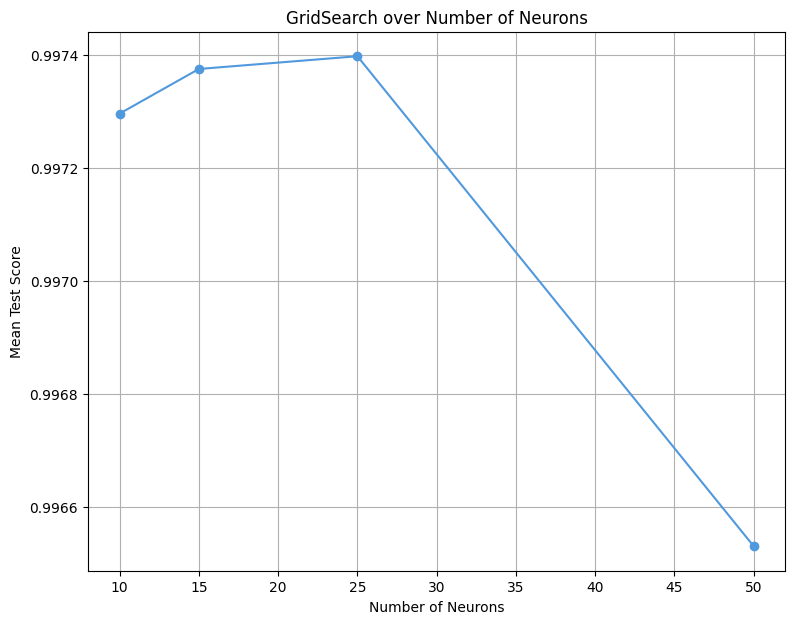

In [15]:
# Don't foret to run the 'create_model_neurons()' cell
with open('num_neurons.pickle', 'rb') as target:
    neurons_load = pickle.load(target)
num_neurons = neurons_load.cv_results_['param_model__neurons'].compressed()
neurons_means = neurons_load.cv_results_['mean_test_score']
plt.pyplot.figure(figsize=(9,7))
plt.pyplot.plot(num_neurons, neurons_means, marker='o', linestyle='-', color='#5199dd')
plt.pyplot.xlabel('Number of Neurons')
plt.pyplot.ylabel('Mean Test Score')
plt.pyplot.title('GridSearch over Number of Neurons')
plt.pyplot.grid(True)
plt.pyplot.savefig('GridSearchCV_numneurons_saved')
plt.pyplot.show()

# Optimizer

In [8]:
# Funcion without compile since we search for an optimizer
def create_model_algor():
    # Model structure
    model = keras.Sequential()
    model.add(keras.layers.LSTM(25, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dense(1))
    return model

In [9]:
# Create a model with wrapper for sckitlearn
model = KerasRegressor(model=create_model_algor, loss=keras.losses.Huber(), epochs=100, batch_size=10, verbose=0)
# Grid search parameters: https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1 ,cv=5)
grid_result = grid.fit(X_val, Y_val)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.997794 using {'optimizer': 'Adam'}
0.992629 (0.006248) with: {'optimizer': 'SGD'}
0.995836 (0.002205) with: {'optimizer': 'RMSprop'}
0.985072 (0.005235) with: {'optimizer': 'Adadelta'}
0.997794 (0.001343) with: {'optimizer': 'Adam'}


In [10]:
with open('optimizers.pickle', 'wb') as target:
    pickle.dump(grid_result, target, protocol=pickle.HIGHEST_PROTOCOL)

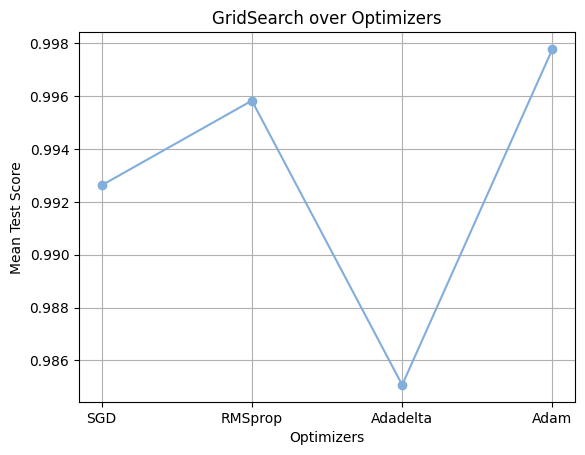

In [11]:
# Don't foret to run the 'create_model_algor()' cell
with open('optimizers.pickle', 'rb') as target:
    optimizer_load = pickle.load(target)
opt = optimizer_load.cv_results_['param_optimizer']
plt.pyplot.plot(opt, means, marker='o', linestyle='-', color='#81aeda')
plt.pyplot.xlabel('Optimizers')
plt.pyplot.ylabel('Mean Test Score')
plt.pyplot.title('GridSearch over Optimizers')
plt.pyplot.grid(True)
plt.pyplot.savefig('GridSearchCV_Optimizer')
plt.pyplot.show()

# Learning Rate (Momentum not available for Adam optimizer)

In [ ]:
# Create a model with wrapper for sckitlearn
model = KerasRegressor(model=create_model_algor, loss=keras.losses.Huber(), optimizer="Adam", epochs=100, batch_size=10, verbose=0)
# Grid search parameters: 0.1, 0.2, 0.3.
learn_rate = [0.001, 0.01]
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9] (discarded since we use Adam)
param_grid = dict(optimizer__learning_rate=learn_rate)#, optimizer__momentum=momentum
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_val, Y_val)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
with open('learning_rate.pickle', 'wb') as target:
    pickle.dump(grid_result, target, protocol=pickle.HIGHEST_PROTOCOL)

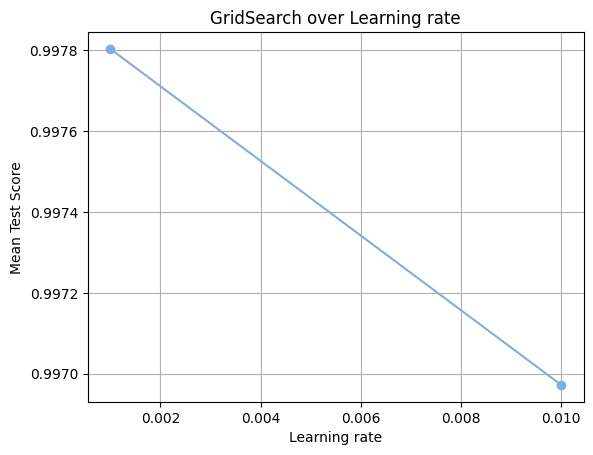

In [19]:
# Don't foret to run the 'create_model_algor()' cell
with open('learning_rate.pickle', 'rb') as target:
    lr_results = pickle.load(target)
means_lr = lr_results.cv_results_['mean_test_score']
lr = lr_results.cv_results_['param_optimizer__learning_rate'].compressed()
plt.pyplot.plot(lr, means_lr, marker='o', linestyle='-', color='#81aeda')
plt.pyplot.xlabel('Learning rate')
plt.pyplot.ylabel('Mean Test Score')
plt.pyplot.title('GridSearch over Learning rate')
plt.pyplot.grid(True)
plt.pyplot.savefig('GridSearchCV_LearningRate_saved')
plt.pyplot.show()

#  batch size & training epochs

In [20]:
# Function to create a model for KerasRegressor
def create_model():
    # Model structure
    model = keras.Sequential()
    model.add(keras.layers.LSTM(25, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dense(1))
    # Model compilation
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer='adam', loss=keras.losses.Huber(), metrics=['mae'])
    return model

In [ ]:
# Create a model with wrapper for sckitlearn
model = KerasRegressor(model=create_model, verbose=0)
# Grid search parameters:
batch_size = [16, 32, 64, 128]
epochs = [10, 50,100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, error_score='raise')
grid_result = grid.fit(X_val, Y_val)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
with open('batch_size_epochs.pickle', 'wb') as target:
    pickle.dump(grid_result, target, protocol=pickle.HIGHEST_PROTOCOL)

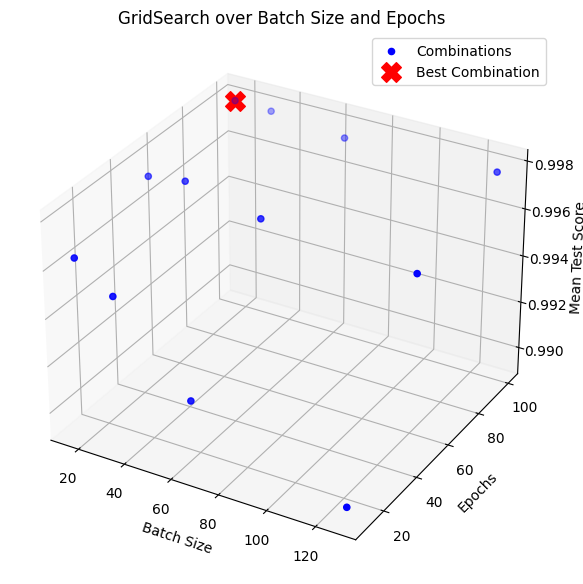

In [21]:
# Using 3D plot
# Best params
with open('/kaggle/input/batch-epoch-pickle/batch_size_epochs.pickle', 'rb') as target:
   bs_epochs_results = pickle.load(target)

best_batch = bs_epochs_results.best_params_['batch_size']
best_epoch = bs_epochs_results.best_params_['epochs']
best_score = bs_epochs_results.best_score_

batches = bs_epochs_results.cv_results_['param_batch_size']
epochs  = bs_epochs_results.cv_results_['param_epochs']
means = bs_epochs_results.cv_results_['mean_test_score']

fig = plt.pyplot.figure(figsize=(7, 8))
ax  = fig.add_subplot(111, projection='3d')
ax.scatter(batches, epochs, means, c='blue', marker='o', label='Combinations')
ax.scatter(best_batch, best_epoch, best_score, c='red', marker='X', s=200, label='Best Combination')

ax.set_xlabel('Batch Size')
ax.set_ylabel('Epochs')
ax.set_zlabel('Mean Test Score')
ax.set_title('GridSearch over Batch Size and Epochs')
ax.legend()
plt.pyplot.savefig('GridSearchCV_Batch_Epoch<_saved')
plt.pyplot.show()